# Binary Images

## by <span style="color:cornflowerblue"> Xueqing Tsang </a>

In [2]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

### Convert CSV to Image File

In [3]:
import pandas as pd
def read_csv(ifile, whitespace=False):
    ''' read a csv file or file with whitespace separators
        and return vx ubyte image file
        only 2D images supported
    '''
    if whitespace:
        df = pd.read_csv(ifile, header=None, sep='\s+')
    else:
        df = pd.read_csv(ifile, header=None, )
    return df.to_numpy(dtype='uint8', copy=True)

def read_img(ifile, flag=cv2.IMREAD_GRAYSCALE):
    return cv2.imread(ifile, flag)

C:\Users\Sophia\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
"""
[dispmvx] uses the matplotlib package to create image presentations.

Parameters:
pvalues : boolean := True to specify that the numerical pixel values should be printed inside each pixel.
                     This is only suitable for small images (x image dimensions less than 40).
cmap : string := Color map of the image array. By default, cmap = "gray" to display grayscale image. To dislay color image,
                 let cmap = None.
"""
def dispmvx(imarray : np.ndarray, pvalues = False, cmap = "gray"):
    plt.imshow(imarray, cmap = cmap)
    if (pvalues and imarray.shape[0] <= 40 and imarray.shape[1] <= 40):
        for y in range(imarray.shape[0]):
            for x in range(imarray.shape[1]):
                plt.text(x, y, imarray[y,x],
                        ha = "center",
                        va = "center",
                        color = "white" if imarray[y,x] <= abs(imarray.max() - imarray.min())/2 else "black"
                        )
    plt.axis("off")
    plt.show()

In [5]:
"""
[embedim] embeds image numpy.array [imarray] with a border of zeros and returns transformed image array [tmarray]. 

Parameters:
dim : (left : int, right : int, lower : int, upper : int) := Border list tuple that defines the dimensions of the bounding
                                                             box of zeros that surrounds [imarray].
"""
def embedim(imarray : np.ndarray, dim):
    tmarray = np.zeros((dim[2] + imarray.shape[0] + dim[3], dim[0] + imarray.shape[1] + dim[1]), dtype = int)
    for y in range(imarray.shape[0]):
            for x in range(imarray.shape[1]):
                  tmarray[y+dim[3], x+dim[0]] = imarray[y,x]
    return tmarray

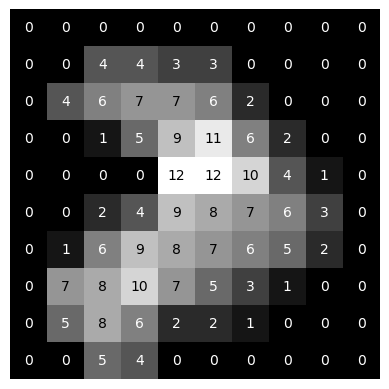

In [6]:
img = read_csv("blob.csv")
dispmvx(img, pvalues = True)

### boundpy
#### Program description
Assume 4-connected foreground and 8-connected background: if pixel value is 0, then background remains set to 0. If pixel value != 0, and if any of the 4-connected pixels adjacent to current pixel is a background, then set current pixel to segment boundary = 255. If pixel value != 0, and pixel not adjacent to any background, then set current pixel value to interior region pixel = 128.

In [7]:
def boundpy(imarray : np.ndarray, of):
    # Make 1 pixel bounding box around entire image array. [tm] is transformed matrix with 
    # 1 pixel bounding box: mapping T(x,y) such that x -> x+1, y -> y+1.
    im = np.copy(imarray)
    tm = embedim(im, (1,1,1,1))

    # Maps pixels in image [im] to either background, boundary, or interior pixel values.
    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            if (tm[y+1,x+1] != 0):
                # Check if boundary:
                if (min(tm[y+1,x], tm[y,x], tm[y,x+1], tm[y,x+2], tm[y+1,x+2], tm[y+2,x+2], tm[y+2,x+1], tm[y+2,x]) == 0):
                    im[y,x] = 255
                else:
                    im[y,x] = 128
        
    cv2.imwrite(of, im)
    return im

#### Example of working program

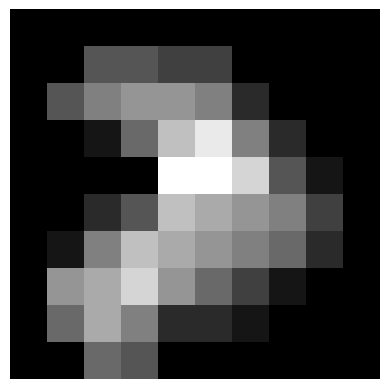

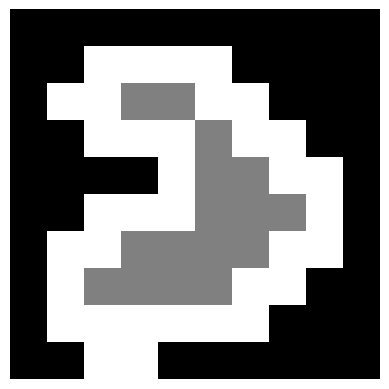

In [8]:
dispmvx(img)
dispmvx(boundpy(img, "blobbound.png"))

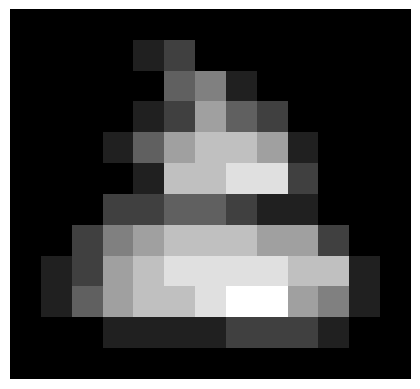

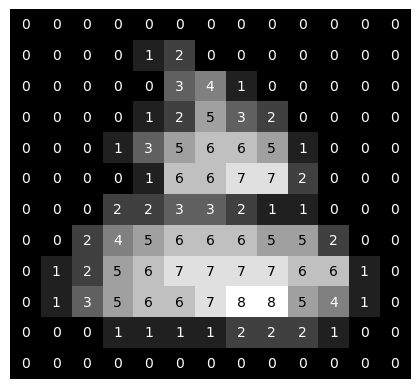

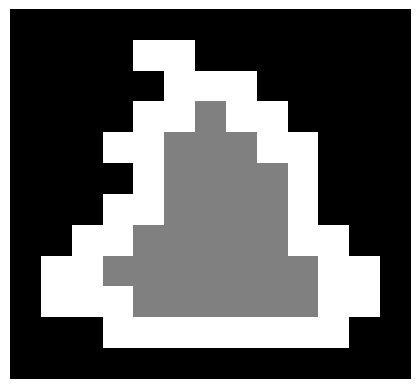

In [9]:
cloud = read_csv("cloud.csv")
dispmvx(cloud)
dispmvx(cloud, pvalues = True)
dispmvx(boundpy(cloud, "cloudbound.png"))

#### 4.4 Examples on full size images

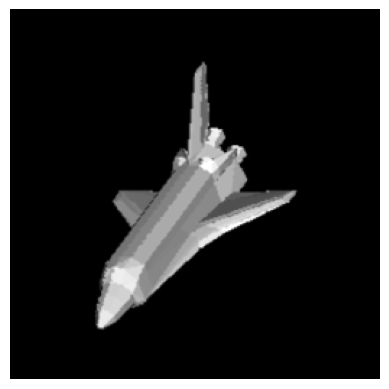

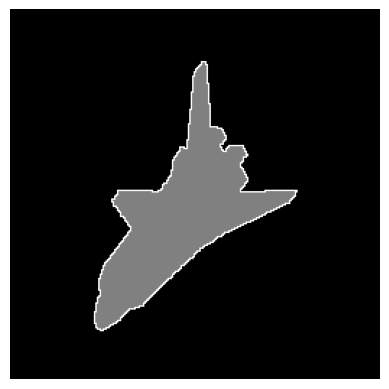

In [10]:
shuttle = read_img("shuttle.png")
dispmvx(shuttle)
dispmvx(boundpy(shuttle, "shuttlefast.png"), pvalues = True)

### slowlabel

#### Program description

In [11]:
#!/usr/bin/env python
""" slowlabel labels connected components with the recursive method.
    Is slow for large images.
"""

def slowlabel(imarray : np.ndarray, of):
    im = np.copy(imarray)
    tm = embedim(im, (1,1,1,1))

    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            im[y,x] = 0
    label = 1

    def setlabel(x : int, y : int, label : int):
        im[y,x] = label
        if (tm[y,x+1] != 0 and im[y-1,x] == 0): setlabel(x,y-1,label)
        if (tm[y+1,x+2] != 0 and im[y,x+1] == 0): setlabel(x+1,y,label)
        if (tm[y+2,x+1] != 0 and im[y+1,x] == 0): setlabel(x,y+1,label)
        if (tm[y+1,x] != 0 and im[y,x-1] == 0): setlabel(x-1,y,label)
      
    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            # Search for unlabeled objects.
            if (tm[y+1,x+1] != 0 and im[y,x] == 0): 
                setlabel(x,y,label)
                label = label + 1
                
    cv2.imwrite(of, im)
    return im

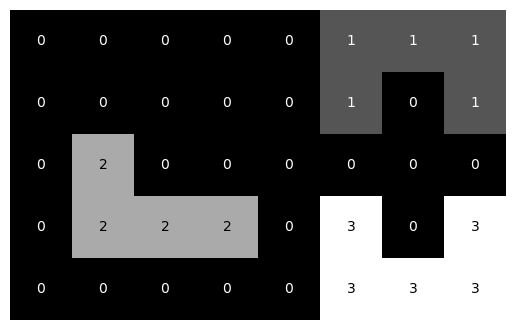

In [12]:
test = read_csv("testim4.csv")
dispmvx(slowlabel(test, "testim4slow.png"), pvalues = True)

### cclabel

### Program description
Let foreground be 4-connected, meaning that only pixels adjacent to the current pixel
will be considered part of the same object, and therefore, given the same label. The program [cclabel.py] labels connected components using a sequential method that iterates over all pixels in the input binary image twice.
First pass: when an object pixel is visited, the adjacent pixel above (Pu = im[y-1,x]) and to the left (Pl = im[y,x-1]) of the pixel (im[y,x]) are checked if labeled or not. If Pu or Pl are labeled, let im[y,x] = Pu or Pl. If neither Pu, Pl are labeled, assume im[y,x] is a new object, and give it a new label = label + 1. 
Second pass: sometimes Pu and Pl are both labeled. In the case that Pu != Pl for im[y,x], add to the equivalence table that labels Pu and Pl are equivalent, and set im[y,x] = Pu for now. During the second pass, merge all objects together with equivalent labels.

In [13]:
#!/usr/bin/env python
""" cclabel labels connected components with the sequential method.
    Runs faster than [slowlabel.py]
"""

def cclabel(imarray : np.ndarray, of):
    im = np.copy(imarray)
    tm = embedim(im, (1,1,1,1))

    # Set all pixels in [im] to 0.
    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            im[y,x] = 0

    label = 0
    equiv_map = {} # [equiv_map] represents the equivalent table that shows equivalency relation between different labels.

    # First pass over the image array: for all object pixels, first checks if adjacent above (Pu) and left (Pl) pixels are labeled, and if they are, let im[y,x] = Pu or Pl. If neither Pu, Pl are labeled, assume im[y,x] is a new object, and give it a new label = label + 1.
    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            # Search for unlabeled objects. If pixel unlabeled, check if Pl, Pu have labels. If not, create new label, else label pixel Pl or Pu.
            if (tm[y+1,x+1] != 0 and im[y,x] == 0): 
                # Give im[y,x] label Pu.
                if (im[y-1,x] != 0): 
                    im[y,x] = im[y-1,x]
                # Give im[y,x] label Pl.
                elif (im[y, x-1] != 0): im[y,x] = im[y,x-1]
                # If Pl, Pu do not have label, increment label.
                else:
                    label = label + 1
                    im[y,x] = label

                # If im[y,x] is an object, Pu and Pl have different labels, make labels Pu, Pl equivalent.
                if (im[y, x-1] != im[y-1, x] and min(im[y, x-1], im[y-1, x]) != 0): 
                    if (im[y, x-1] in equiv_map): 
                        equiv_map[im[y-1,x]] = equiv_map.get(im[y, x-1])
                    elif (im[y-1, x] in equiv_map): 
                        equiv_map[im[y,x-1]] = equiv_map.get(im[y-1, x])
                    else:
                        equiv_map[im[y, x-1]] = min(im[y, x-1], im[y-1, x])
                        equiv_map[im[y-1,x]] = min(im[y, x-1], im[y-1, x])

    # Second pass over the labeled image array: merge all objects together with equivalent labels.
    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            if (im[y,x] in equiv_map): 
                # Give im[y,x] label Pu.
                im[y,x] = equiv_map.get(im[y,x])
                
    cv2.imwrite(of, im)
    return im


#### Small image tests
        

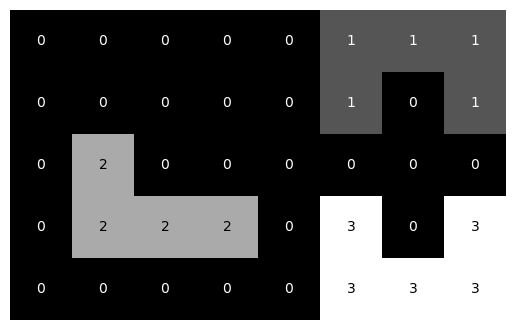

In [14]:
test = read_csv("testim4.csv")
dispmvx(cclabel(test, "testim4fast.png"), pvalues = True)

### Large image tests

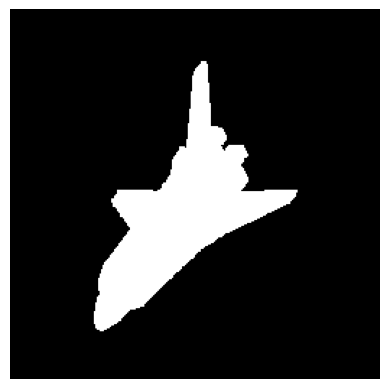

In [15]:
shuttle = read_img("shuttle.png")
dispmvx(cclabel(shuttle, "shuttlefast.png"), pvalues = True)

### slowgrow

### Program description
...

In [16]:
#!/usr/bin/env python
""" Region growing.
"""

def slowgrow(imarray : np.ndarray, of, rng : int, labeling : bool):
    im = np.copy(imarray)
    tm = embedim(im, (1,1,1,1))

    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            im[y,x] = 0
    
    label = 1

    def setlabel (x, y, label):
        im[y,x] = label
        if (tm[y,x+1] != 0 and im[y-1,x] == 0 and abs(int(tm[y,x+1])-first) < rng): setlabel(x,y-1,label)
        if (tm[y+1,x+2] != 0 and im[y,x+1] == 0 and abs(int(tm[y+1,x+2])-first) < rng): setlabel(x+1,y,label)
        if (tm[y+2,x+1] != 0 and im[y+1,x] == 0 and abs(int(tm[y+2,x+1])-first) < rng): setlabel(x,y+1,label)
        if (tm[y+1,x] != 0 and im[y,x-1] == 0 and abs(int(tm[y+1,x])-first) < rng): setlabel(x-1,y,label)
        
    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            # Search for unlabeled objects.
            if (tm[y+1,x+1] != 0 and im[y,x] == 0): 
                first = tm[y+1, x+1]
                setlabel(x,y,first if labeling else label)
                label = (label + 1) % 256
    
    cv2.imwrite(of, im)
    return im

### vits

### Program description
...

In [17]:
#!/usr/bin/env python
""" vits
"""
from typing import Optional
import sys
sys.setrecursionlimit(99999)

def vits(imarray : np.ndarray, of, thresh : Optional[int] = None):
    im = np.copy(imarray)
    tm = embedim(im, (1,1,1,1))
        
    if thresh != None:
        thresh = thresh
    else: 
        thresh = np.average(im)
        
    # Create a blank histogram of 256 bins
    hist = np.zeros(256)

    # Compute the histogram
    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            hist[im[y,x]]+=1
        
    old_avg1 = 0.
    old_avg2 = 0.
    new_avg1 = 255.
    new_avg2 = 255.

    count = 0
    while (old_avg1 != new_avg1 or old_avg2 != new_avg2):
        count += 1
        old_avg1 = new_avg1
        old_avg2 = new_avg2
        new_avg1 = 0
        new_avg2 = 0
        totalpixel1 = 0
        totalpixel2 = 0
        for val in range(256):
            # from 0 to thresh: avg = (#_of_pixels * pixel_value)/totalpixel1:
            if (val <= thresh):
                totalpixel1 += hist[val]
                new_avg1 += hist[val] * float(val)
            # from (thresh, 256]:
            else:
                totalpixel2 += hist[val]
                new_avg2 += hist[val] * float(val)
        new_avg1 = new_avg1/totalpixel1
        new_avg2 = new_avg2/totalpixel2
        thresh = (new_avg1 + new_avg2)/2

    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            if (im[y,x] >= thresh): 
                im[y,x] = 255
            else:
                im[y,x] = 0
                
    cv2.imwrite(of, im)
    return im

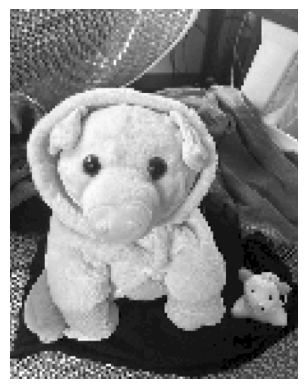

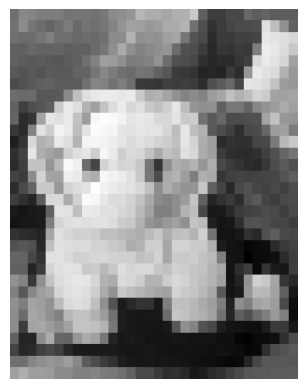

In [102]:
segment_tree = []
# Figure out how to make R a node and R1, R2, R3, R4 its children.
# For now have dict contain key = region (node), value = [R1, R2, R3, R4]
dict = {}
""" Horowitz Pavlidis Split and Merge.
    https://ieeexplore.ieee.org/document/1234069
    https://courses.cs.duke.edu/spring06/cps296.1/handouts/Horowitz%20Pavlidis%201976.pdf
    partition R into subsets R1, R2, R3, R4 s.t. R1 U R2 U R3 U R4 = R and intersection of 
    any Ri, Rj for i != j and i, j in [4] is disjoint.
    P(R) := "True if homogenous -> if s_2 < thresh for all I(r,c) in R"
    
    PROCEDURE:
    1) Begins with arbitrary partition R1 U R2 U R3 U R4 = R where P(R) = false.
    2) Repeat partitioning.
    3) Produces a partition that eventually satisfies both P(Ri) = true for all i (all regions
    are homogenous) and P(Si U Sj) = false for all i != j (differenet regions are not homogenous
    with one another).

    Quadtree Structure:
    1) X is the root of the tree
    2) Successors of the node coresponding to a subset S of X are nodes corresponding to 
    disjoint, collectively exhaustive subsets of S (S partitions into these nodes)
    3) Leaves of the tree represent the smallest subsets of X (can modify, could be single pixels)

    Segment Tree:
    Data structure that stores data about range of elements in nodes as a tree. 

    Given region R with upper left corner pixel (x,y), width [imarray.shape[0]] and
    length [imarray.shape[1]]: split into 
    a) R1 = rows: [x,width/2-1], cols: [y,length/2-1] 
    b) R2 = rows: [width/2,width], cols: [y,length/2-1]        R: |    | -> |R1|R2|
    c) R3 = rows: [x,width/2-1], cols: [length/2,length]          |    |    |R3|R4|
    d) R4 = rows: [width/2,width], cols: [length/2,length]
    When Rn is homogenous, assign it a value: avg pixel intensity for all I(r,c) in Rn.
    
    split_tree():
        if R is not homogenous enough (!P(R)) then 
            split R in four equally sized regions R1, R2, R3, R4
            for r in R1, R2, R3, R4:
                Split(r)
    merge_tree(Rn):
        loop
            get 2 regions r and r' in Rn that are neighbor and similar
            merge r and r'
        until no regions can merge
"""

def split_tree (imarray, edge, thresh):
    I_ = (1/np.size(imarray)) * 1/np.sum(imarray)
    s_2 = (1/(np.size(imarray)-1)) * np.sum(imarray - I_) ** 2

    # edge = (x_u, x_d, y_l, y_r)
    dict[edge] = []
    # # Not homogenous enough.
    if s_2 >= thresh and imarray.shape[0] > 4 and imarray.shape[1] > 4:
        # Partition into R1, R2, R3, R4
        row_split = int(imarray.shape[0]//2) # Horizontal split
        col_split = int(imarray.shape[1]//2) # Vertical split
        # R1 = rows: [x,width/2-1], cols: [y,length/2-1] 
        # R2 = rows: [x,width/2-1], cols: [length/2,length] 
        # R3 = rows: [width/2,width], cols: [y,length/2-1]       
        # R4 = rows: [width/2,width], cols: [length/2,length]
        split = [(edge[0], (edge[0]+row_split)-1, edge[2], (edge[2]+col_split)-1),
                (edge[0], (edge[0]+row_split)-1, (edge[2]+col_split), edge[3]),
                ((edge[0]+row_split), edge[1], edge[2], (edge[2]+col_split)-1),
                ((edge[0]+row_split), edge[1], (edge[2]+col_split), edge[3])]
        count = 0
        for row in np.vsplit(imarray, [row_split]):
            for region in np.hsplit(row, [col_split]):
                dict[edge].append(region)
                if region.shape[0] > 10 and region.shape[1] > 20:
                    split_tree (region, split[count], thresh)
                else:
                    avg = np.average(region)
                    for y in range(split[count][0], split[count][1]+1):
                        for x in range(split[count][2], split[count][3]+1):
                            im[y,x] = avg
                    segment_tree.append(region)
                count += 1
    else:
        dict[edge].append(imarray)
        segment_tree.append(imarray)

def split_merge (imarray):
    global im
    im = np.copy(imarray)
    tm = embedim(im, (1,1,1,1))
    # [node] contains all partitioned regions.
    node = [im]
    split_tree(im, (0, imarray.shape[0]-1, 0, imarray.shape[1]-1), 50) 
    # for k in dict.items():
    #     print(k)
    return im

dispmvx(read_img("piggy.png"))
split = split_merge(read_img("piggy.png"))
# dispmvx(read_csv("blob.csv"))
# split = split_merge(read_csv("blob.csv"))
dispmvx(split)
# for arr in split_merge(read_csv("blob.csv")):
#     dispmvx(arr)

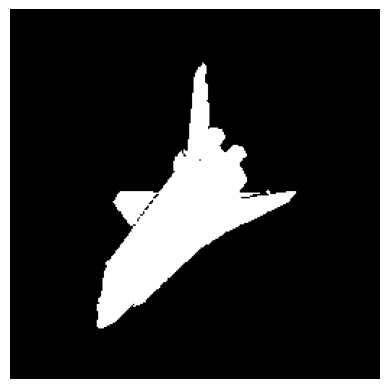

In [20]:
dispmvx(vits(read_img("shuttle.png"), "shuttlev.png"))

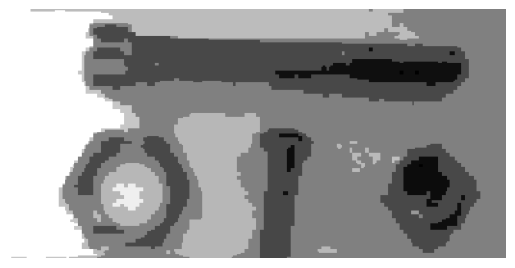

In [21]:
dispmvx(slowgrow(read_img("nail.png"), "nailv.png", rng = 53, labeling = True))
